In [8]:
import os
import nglview as ng
import gromacs as gmx
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re
import mdtraj as md
from IPython.display import display
from IPython.display import Image
%matplotlib widget

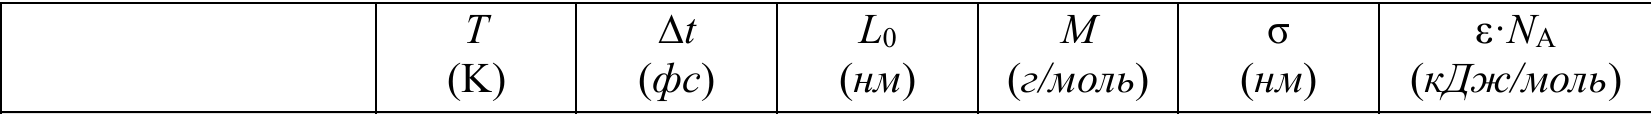

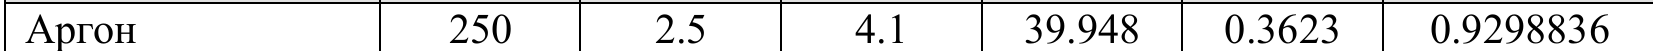

Изменил single.gro файл, чтобы размерв ячейки были $0,41^3$, чтобы после размножения получить требуемую $L_0$. Частицу поместил в центр ячейки

In [23]:
!cat single.gro

the only LJ atom in the cell
    1
    1RESID Ar    1   0.205   0.205   0.205  0.1324  0.1307  0.0385
   0.41000   0.41000   0.41000


Размножил частицу в 1000 раз, получил ячейку размером $4.1^3$ нм

In [25]:
!gmx genconf -f single.gro -nbox 10 10 10 -o 0/Ar_0

               :-) GROMACS - gmx genconf, 2025.4-conda_forge (-:

Executable:   /home/ivank/miniconda3/bin.AVX2_256/gmx
Data prefix:  /home/ivank/miniconda3
Working dir:  /home/ivank/tasks/task_3
Command line:
  gmx genconf -f single.gro -nbox 10 10 10 -o 0/Ar_0


GROMACS reminds you: "Cut It Deep and Cut It Wide" (The Walkabouts)



Визуализация изначальной структуры до проведения первого моделирования:

In [ ]:
view = ng.show_structure_file("0/Ar_0.gro")
display(view)
view.download_image(filename='_1.png')

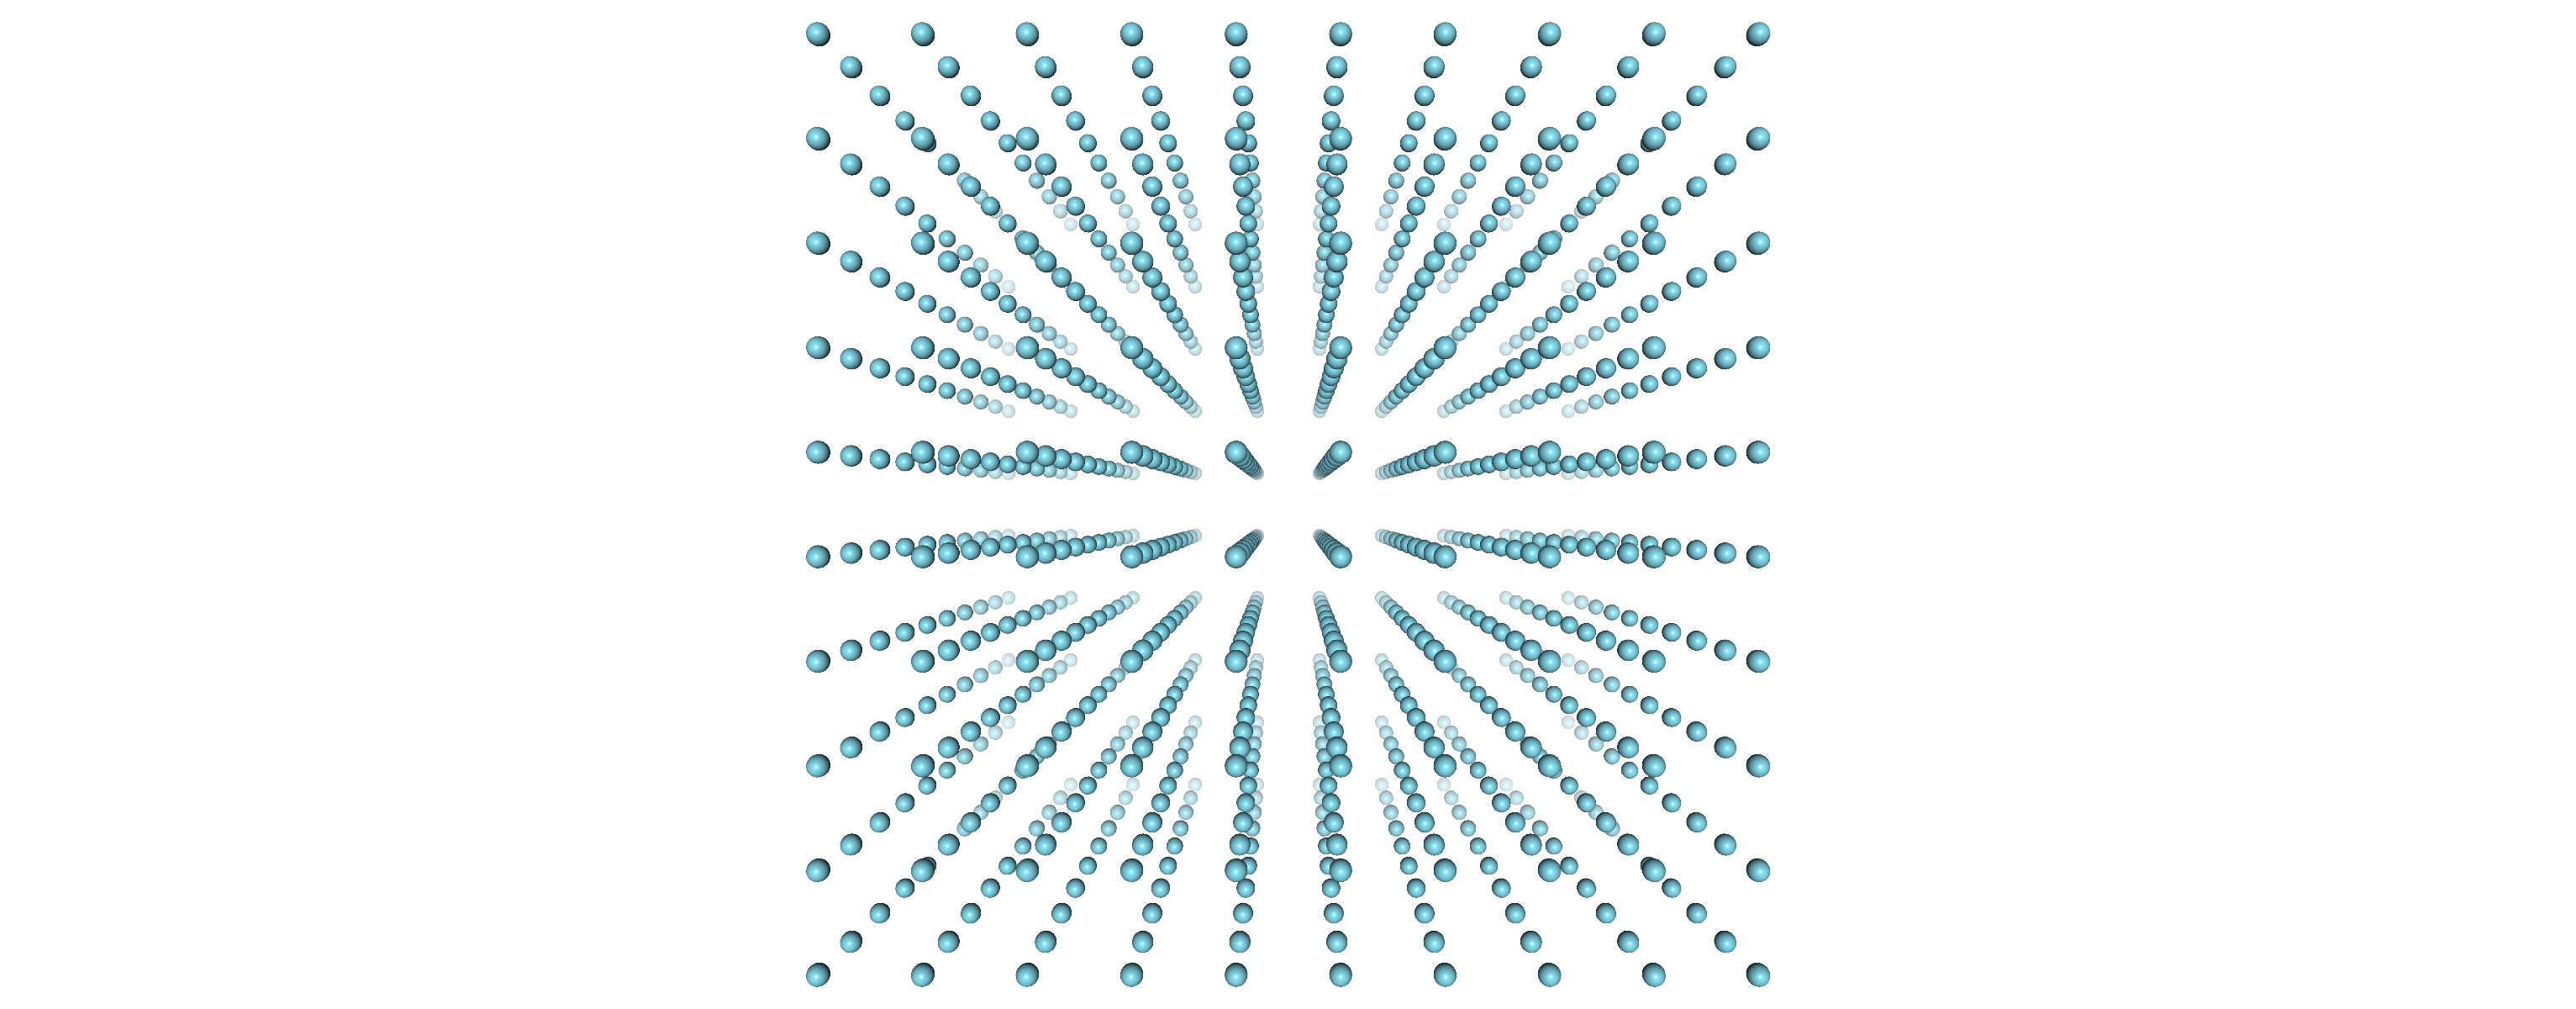

In [21]:
# выполнять из корневой директории
os.chdir("0")

Провел 11 моделирований, в каждом объем ячейки увеличивался в $1.2^3$ по отношению к предыдущему. Результаты расчетов сохранены в папках с именами, соответствующими номеру расчета

In [ ]:
for i in range(1, 12):
    os.mkdir(f"../{i}")
    os.chdir(f"../{i}")
    if i == 1:
        scale_factor = 1
    else: scale_factor = 1.2
    gmx.editconf(f=f"../{i-1}/Ar_{i-1}.gro",
            o=f"Ar_{i-1}_scaled",
            scale=f"{scale_factor}")
    gmx.grompp(f="../mdp.mdp",
          c=f"Ar_{i-1}_scaled",
          p="../Ar.top",
          o=f"Ar_{i}.tpr")
    gmx.mdrun(deffnm=f"Ar_{i}",
         v=True)
    

Посмотрим на систему после первого моделирования:

In [ ]:
view = ng.show_structure_file("1/Ar_1.gro")
display(view)
view.download_image(filename='_2.png')

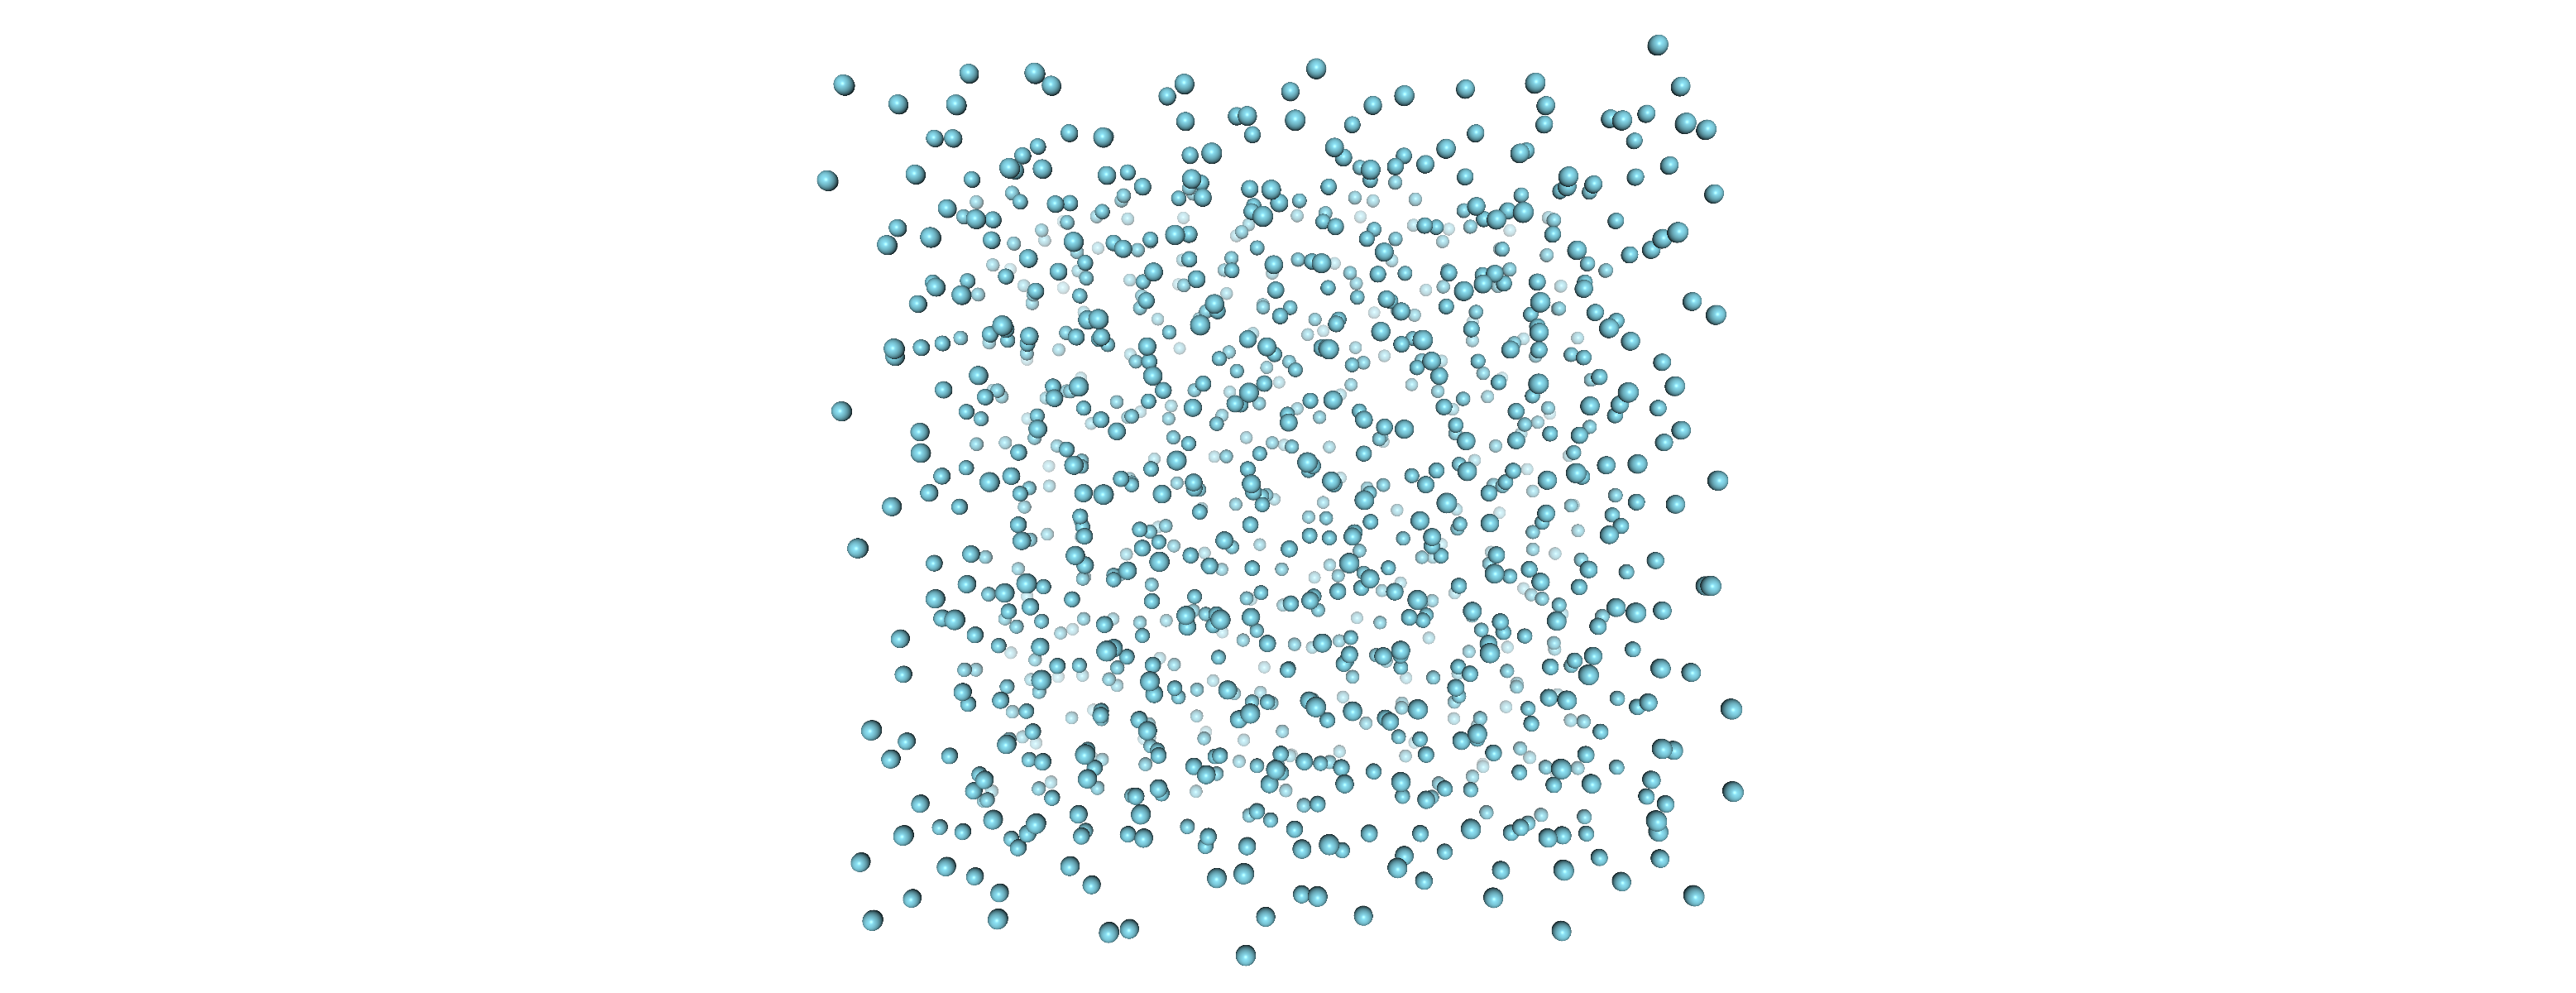

... и после последнего:

In [ ]:
view = ng.show_structure_file("11/Ar_11.gro")
display(view)
view.download_image(filename='_3.png')

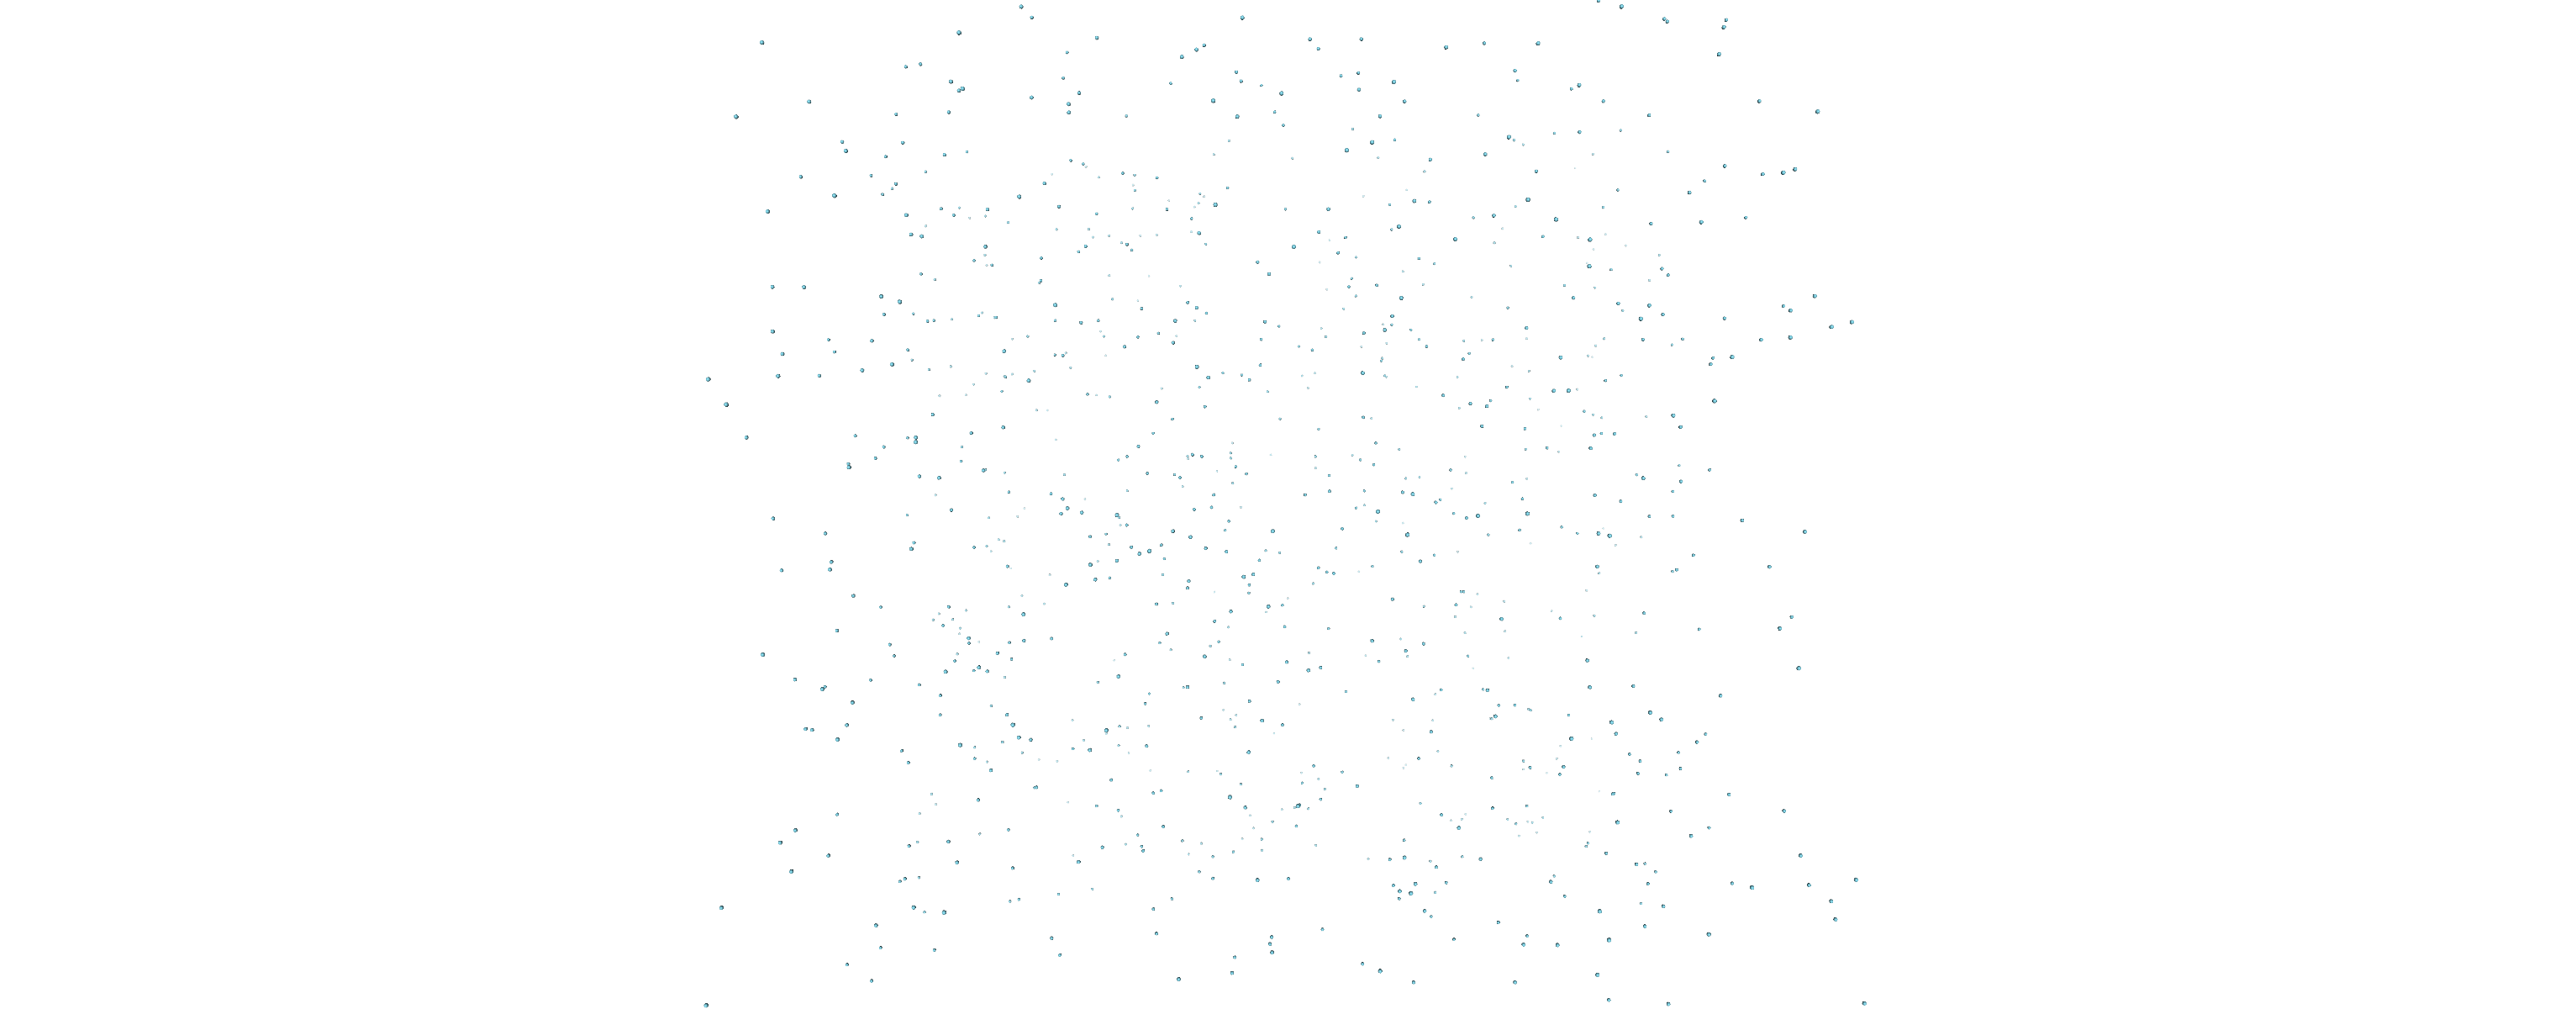

Как и ожидалось, плотность в последнем случае много меньше исходной плотности

# Построение $P-V$ диаграммы

Посмотрел зависимость давления от времени в первом моделировании, чтобы понять, сколько времени в начале пропускать и не брать для расчета средних значений давления.

In [14]:
os.chdir("/home/ivank/tasks/task_3")

In [15]:
os.getcwd()

'/home/ivank/tasks/task_3'

In [8]:
cmd = f'echo -e "10\\n0" | gmx energy -f 1/Ar_1.edr -s 1/Ar_1.tpr -o 1/Ar_1_result_to_check.xvg -nmol 1000'
result = subprocess.run(
    cmd,
    shell=True,
    capture_output=True,
    text=True,
    check=False
)

In [9]:
output = result.stdout + result.stderr
match = re.search(r'Pressure\s+(-?\d+\.?\d*)', output)
if match:
    print(f"Average pressure in first experiment: {float(match.group(1))} bar")


Average pressure in first experiment: 1129.86 bar


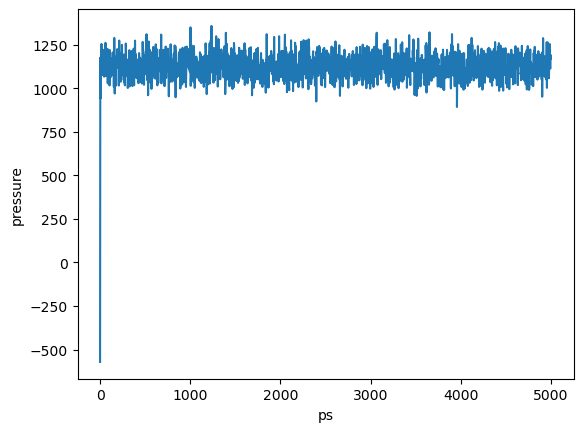

In [23]:
pressure = np.genfromtxt([i for i in open('1/Ar_1_result_to_check.xvg').read().splitlines()
                           if not i.startswith(('#','@'))])
plt.plot(*pressure.T)
plt.xlabel('ps')
plt.ylabel('pressure')
plt.show()

После 50 пикосекунд система приходит в равновесие, поэтому для усреднения буду брать значения давления после этого промежутка времени.

In [3]:
skip = 50

Запросил значения давления из .edr файлов для каждого моделирования, из вывода в консоль получил средние значения давлений и их сохраним в файл average_pressures.txt

In [ ]:
p_list = []
V_list = []
for i in range(1, 12):
    cmd = f'echo -e "10\\n0" | gmx energy -f {i}/Ar_{i}.edr -s {i}/Ar_{i}.tpr -o {i}/Ar_{i}_result.xvg -b 50 -nmol 1000'
    result = subprocess.run(
        cmd,
        shell=True,
        capture_output=True,
        text=True,
        check=False
    )
    output = result.stdout + result.stderr
    match = re.search(r'Pressure\s+(-?\d+\.?\d*)', output)
    if match:
        p_list.append(float(match.group(1)))
    else: print("Not found!")

    with open(f"{i}/Ar_{i}.gro") as gro:
        lines = gro.readlines()
    last_line = lines[-1].strip()
    length = last_line.split(" ")[0]
    volume = float(length)**3 
    V_list.append(volume)


In [9]:
os.getcwd()

'/home/ivank/tasks/task_3'

In [10]:
# если оперативная память очистилась, запустить, чтобы загрузить в память V и p
with open("average_pressures_bar.txt") as file:
    p_list_str = file.read().split(" ")
p_list = [float(p) for p in p_list_str]
V_list = []
for i in range(1, 12):
    with open(f"{i}/Ar_{i}.gro") as gro:
            lines = gro.readlines()
    last_line = lines[-1].strip()
    length = last_line.split(" ")[0]
    volume = float(length)**3 
    V_list.append(volume)


Объем в $нм^3$

In [11]:
V_list

[68.92099999999998,
 119.09548799999999,
 205.79700326399998,
 355.61722164019204,
 614.5065589942519,
 1061.8667094436537,
 1834.9047746412425,
 3170.7180404992364,
 5479.002638725202,
 9467.716559717152,
 16360.214215191234]

Давление в $бар$

In [12]:
p_list

[1130.02,
 291.574,
 148.888,
 87.7686,
 52.5294,
 31.2065,
 18.3416,
 10.7198,
 6.24473,
 3.62344,
 2.10131]

Перевел давление в $Па$, а объем в $м^3$

In [13]:
p_list_Pa = [p*100000 for p in p_list]
V_list_m3 = [V*1e-27 for V in V_list]

Исходя из числа частиц в ячейке посчитал молярный объем

In [14]:
N_a = 6e23
N = 1000
V_list_m3_molar = [V/(N/N_a) for V in V_list_m3]

По уравнению состояния идеального газа, посчитал, какой у него будет объем при каждом давлении, полученном из результатов моделирований.

In [15]:
T = 250
R = 8.31
p_list_ig_Pa = [R*T/V for V in V_list_m3_molar]

На одном графике изобразил изотермы (T=250 К) для исследуемого газа (Ar) и для идеального газа.

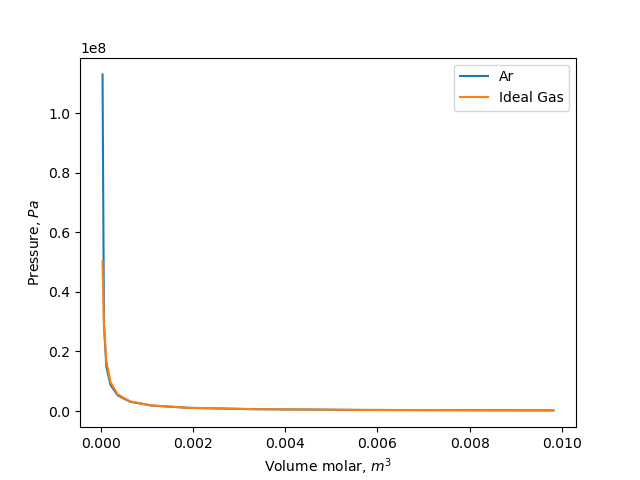

In [16]:
plt.close()
plt.plot(V_list_m3_molar, p_list_Pa, label="Ar")
plt.plot(V_list_m3_molar, p_list_ig_Pa, label="Ideal Gas")
plt.ylabel("Pressure, $Pa$")
plt.xlabel("Volume molar, $m^3$")
plt.legend()
plt.show()

Изотермы совпадают, поэтому поведение аргона можно описать уравнением идеального газа

# Расчет вириальных коэффициентов

Разложение фактора сжимаемости по степеням обратного молярного объема:
$$
Z = \frac{pV_m}{RT} = 1+\frac{B}{V_m} + \frac{C}{V_m^2} + ...
$$
$$
(Z-1)V_m = B + \frac{C}{V_m}
$$
Если построить зависимость $y = (Z-1)V_m$ от $x = \frac{1}{V_m}$, то должна получиться прямая, при этом отрезок, отсекаемый на оси y, будет соответствовать вириальному $B$, а тангенс угла наклона - коэффициенту $C$

Посчитал фактор сжимаемости для каждого давления

In [17]:
z_list = []
for i in list(range(len(V_list_m3_molar))):
    V_m = V_list_m3_molar[i]
    p = p_list_Pa[i]
    z = p*V_m/(R*T)
    z_list.append(z)

In [18]:
z_list

[2.2493027702527066,
 1.0028923557577472,
 0.8849300858330811,
 0.9014303445270574,
 0.932264572997333,
 0.9570294142455851,
 0.9719881419367458,
 0.9816451480301435,
 0.9881557299097886,
 0.9907784228488525,
 0.9928630103255881]

Построил зависимость фактора сжимаемости от давления

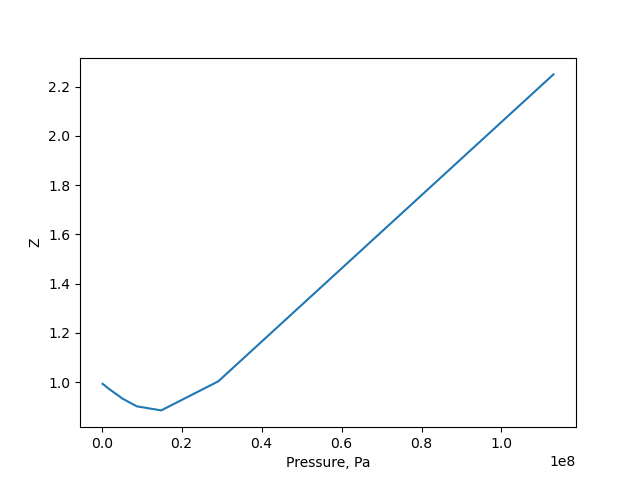

In [19]:
plt.close()
plt.plot(p_list_Pa, z_list)
plt.xlabel("Pressure, Pa")
plt.ylabel("Z")
plt.show()

Построил зависимость $(Z-1)V_m$ от $\frac{1}{V_m}$, чтобы найти вириальные коэффициенты

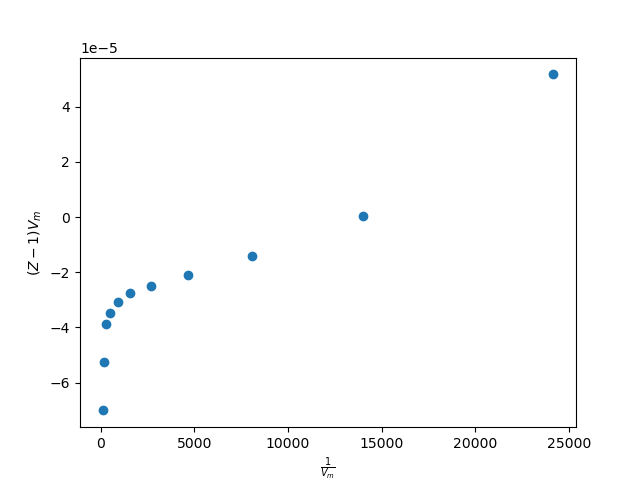

In [20]:
x_list = []
y_list = []
for i in list(range(len(V_list_m3_molar))):
    V_m = V_list_m3_molar[i]
    z = z_list[i]
    x_list.append(1/V_m)
    y = (z-1)*V_m
    y_list.append(y)

plt.close()
plt.scatter(x_list, y_list)
plt.xlabel(r"$\frac{1}{V_m}$")
plt.ylabel(r"$(Z-1)V_m$")
plt.show()

Зависимость не линейная, не понятно, как определить вириальные коэффициенты

In [21]:
with open("virial_coef.txt", "w") as file:
    lines = [f'{x} {y}\n' for x, y in zip(x_list, y_list)]
    file.writelines(lines)

# Область низких плотностей

Еще раз проанализируем область низких плотностей, начиная со случайной конфигурации. 1000 исходных молекул вставим в ячейку $7^3$ в случайном порядке.

In [ ]:
!gmx insert-molecules -ci single.gro -nmol 1000 -o extra/system_1.gro -box 7 7 7 

Визуализация полученной системы.

In [ ]:
view = ng.show_structure_file("extra/0/system.gro")
display(view)
view.download_image(filename='extra/initial_random.png')

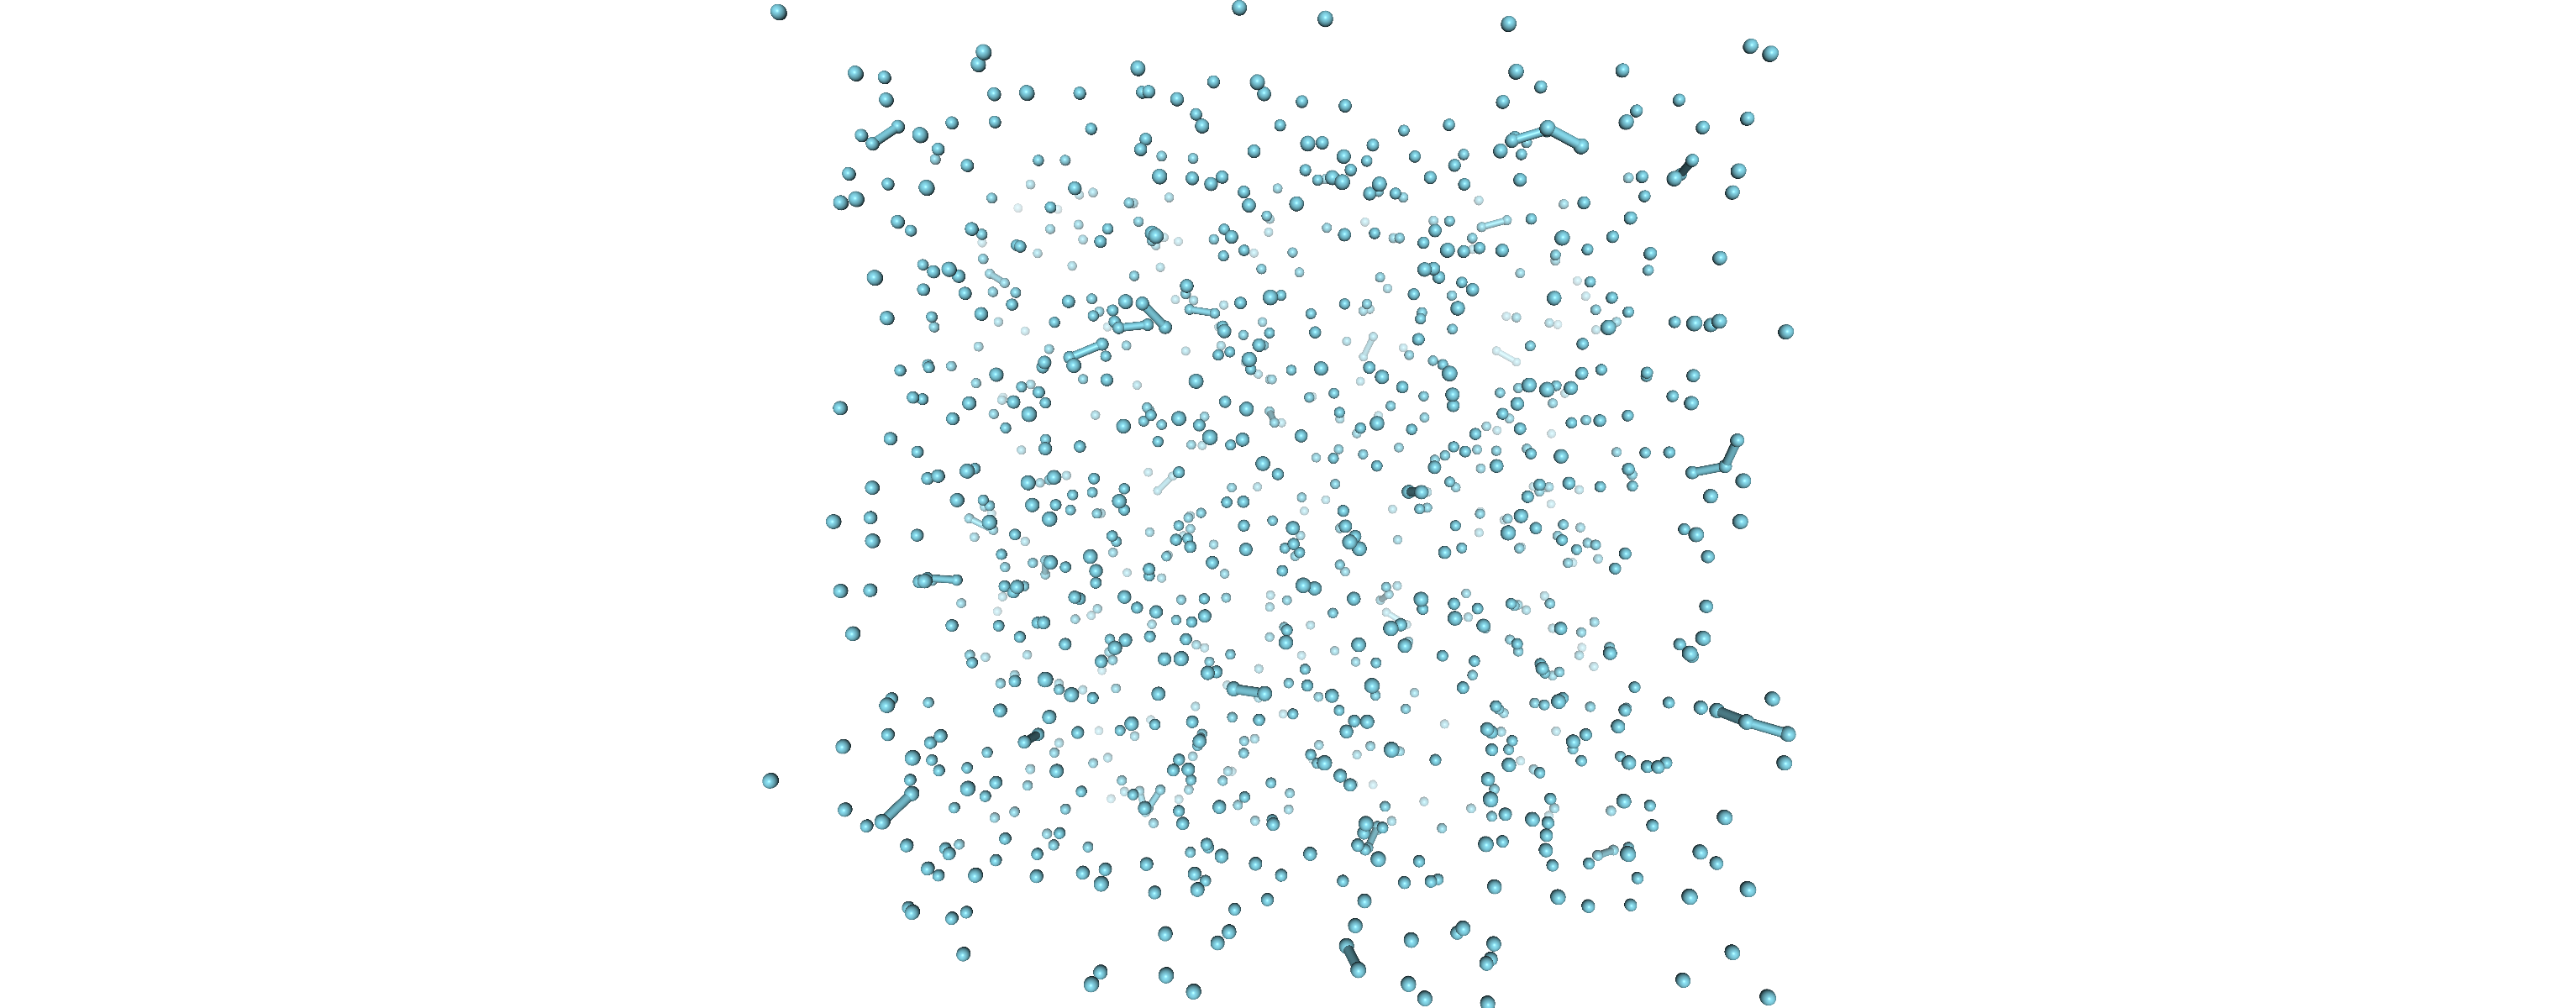

Проведем 15 расчетов, каждый раз увеличивая размер ячейки в $1.1^3$ раз, тем самым получим больше данных, относящихся к разреженной области. Но сначала нужно минимизировать энергию в системе, чтобы она не взорвалась в процессе моделирования. Для минимизации используем другой min.mdp:

In [27]:
!cat em.mdp

integrator = steep
nsteps = 5000
nstxout = 10

In [ ]:
!gmx grompp -f em.mdp -c extra/0/system.gro -p Ar.top -o extra/0/Ar_0.tpr

In [59]:
os.chdir("extra/0")

In [66]:
os.getcwd()

'/home/ivank/tasks/task_3/extra/0'

In [ ]:
!gmx mdrun -deffnm Ar_0 -v

Запросим данные по изменению энергии и отобразим на графике

In [ ]:
!printf "Potential\n0\n" | gmx energy -f Ar_0.edr -o potential.xvg

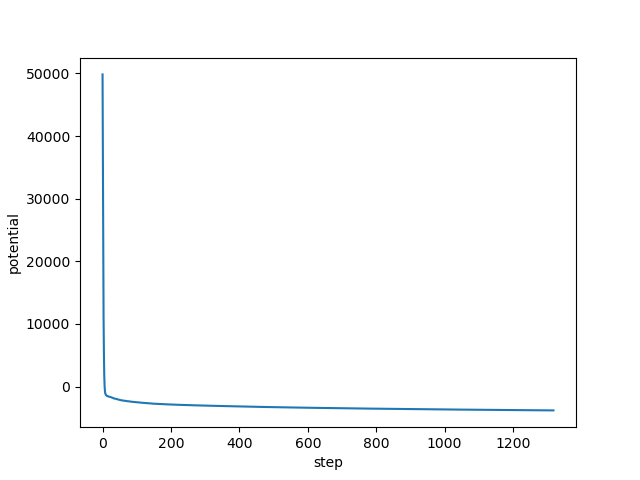

In [65]:
import numpy as np
import matplotlib.pyplot as plt
potential = np.genfromtxt([i for i in open('potential.xvg').read().splitlines()
                           if not i.startswith(('#','@'))])
plt.close()
plt.plot(*potential.T)
plt.xlabel('step')
plt.ylabel('potential')
plt.show()

Как видно, система пришла в энергетическое равновесие, можно начинать моделирование. Выполним 15 моделирований по тому же алгоритму, что и раньше, результаты сохраним в папках с номерами, соответствующими номеру расчета в папке extra 

In [ ]:
for i in range(4, 15):
    os.chdir("/home/ivank/tasks/task_3")
    os.mkdir(f"extra/{i}")
    os.chdir(f"extra/{i}")
    if i == 1:
        scale_factor = 1
    else: scale_factor = 1.1
    gmx.editconf(f=f"../{i-1}/Ar_{i-1}.gro",
            o=f"Ar_{i-1}_scaled",
            scale=f"{scale_factor}")
    gmx.grompp(f="../../mdp.mdp",
          c=f"Ar_{i-1}_scaled",
          p="../../Ar.top",
          o=f"Ar_{i}.tpr")
    gmx.mdrun(deffnm=f"Ar_{i}",
         v=True)
    

In [22]:
os.getcwd()

'/home/ivank/tasks/task_3'

In [28]:
os.chdir("/home/ivank/tasks/task_3/extra/")

Соберем статистику по средним давлениям в каждом моделировании

In [24]:
p_list = []
V_list = []
for i in range(1, 15):
    cmd = f'echo -e "10\\n0" | gmx energy -f {i}/Ar_{i}.edr -s {i}/Ar_{i}.tpr -o {i}/Ar_{i}_result.xvg -b 50 -nmol 1000'
    result = subprocess.run(
        cmd,
        shell=True,
        capture_output=True,
        text=True,
        check=False
    )
    output = result.stdout + result.stderr
    match = re.search(r'Pressure\s+(-?\d+\.?\d*)', output)
    if match:
        p_list.append(float(match.group(1)))
    else: print("Not found!")

    with open(f"{i}/Ar_{i}.gro") as gro:
        lines = gro.readlines()
    last_line = lines[-1].strip()
    length = last_line.split(" ")[0]
    volume = float(length)**3 
    V_list.append(volume)


In [31]:
p_list

[141.703,
 107.298,
 81.9698,
 62.6519,
 47.85,
 36.5063,
 27.723,
 20.9828,
 15.8646,
 11.9811,
 9.04111,
 6.81384,
 5.12914,
 3.8594]

In [10]:
with open('average_pressures_bar.txt', 'w') as f:
    for p in p_list:
        f.write(f'{p} ')

In [6]:
os.getcwd()

'/home/ivank/tasks/task_3/extra'

In [32]:
# если оперативная память очистилась, запустить, чтобы загрузить в память V и p
with open("average_pressures_bar.txt") as file:
    p_list_str = file.read().strip().split(" ")
p_list = [float(p) for p in p_list_str]
V_list = []
for i in range(1, 15):
    with open(f"{i}/Ar_{i}.gro") as gro:
            lines = gro.readlines()
    last_line = lines[-1].strip()
    length = last_line.split(" ")[0]
    volume = float(length)**3 
    V_list.append(volume)

Проведем такие же операции как для первого набора данных: перевод давлений и объемов в СИ, расчет значений давлений для идеального газа для объемов, соответствующих ячейкам в моделировании, расчитаем фактор сжимаемости.

In [33]:
p_list_Pa = [p*100000 for p in p_list]
V_list_m3 = [V*1e-27 for V in V_list]

In [34]:
N_a = 6e23
N = 1000
V_list_m3_molar = [V/(N/N_a) for V in V_list_m3]

In [35]:
T = 250
R = 8.31
p_list_ig_Pa = [R*T/V for V in V_list_m3_molar]

In [36]:
z_list = []
for i in list(range(len(V_list_m3_molar))):
    V_m = V_list_m3_molar[i]
    p = p_list_Pa[i]
    z = p*V_m/(R*T)
    z_list.append(z)

In [37]:
z_list

[0.8839811696750906,
 0.8909096262238267,
 0.9058868501165286,
 0.9215786003009614,
 0.936824269471121,
 0.9513100062666264,
 0.9615525350523333,
 0.9686672641321348,
 0.9748061550481493,
 0.9798588427706963,
 0.9841622796428179,
 0.9872229748379041,
 0.9891128908957899,
 0.9906021869651639]

Зависимость фактора сжимаемости от давления для области разреженного газа

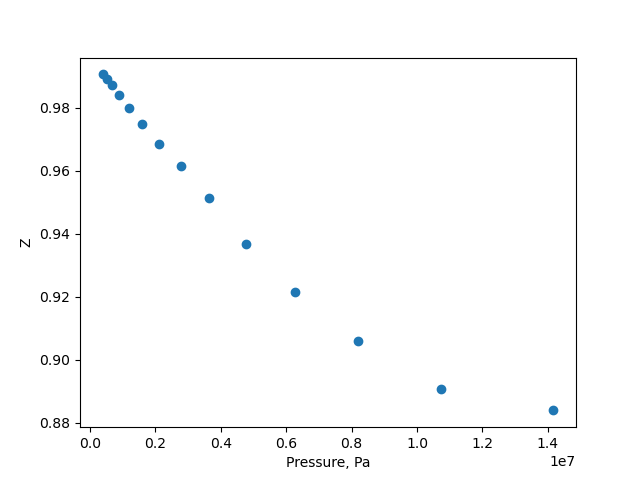

In [39]:
plt.close()
plt.scatter(p_list_Pa, z_list)
plt.xlabel("Pressure, Pa")
plt.ylabel("Z")
plt.show()

In [40]:
os.chdir("..")

Загрузим данные, сохраненные после основной серии расчетов, чтобы нанести на один график с новыми данными и сравнить.

In [42]:
with open("virial_coef.txt") as file:
    lines = file.readlines()

x_list_old, y_list_old = [], []
for line in lines:
    x, y = line.split(' ')
    x_list_old.append(float(x))
    y_list_old.append(float(y))

Нанесем данные, полученные из первой серии расчетов и из второй серии на один график $(Z-1)V_m$ от обратного объема. Оранжевые точки соответствуют значениям, полученным из первой серии расчетов, когда исследовалась вся область концентраций. Синии точки получены из второй серии расчетов, когда более подробно исследовалась область низких концентраций

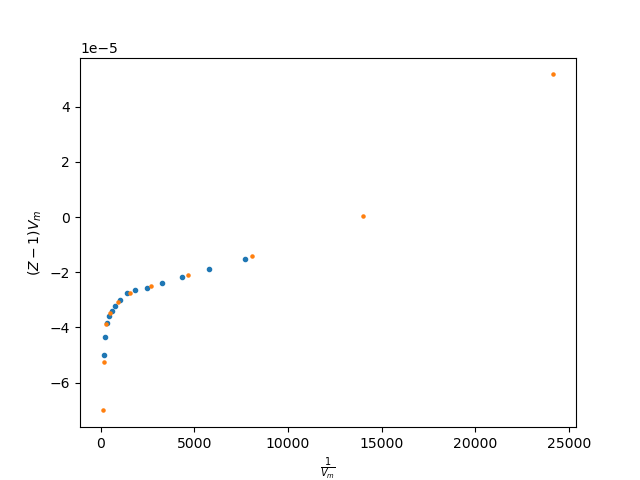

In [45]:
x_list = []
y_list = []
for i in list(range(len(V_list_m3_molar))):
    V_m = V_list_m3_molar[i]
    z = z_list[i]
    x_list.append(1/V_m)
    y = (z-1)*V_m
    y_list.append(y)

plt.close()
plt.scatter(x_list, y_list, s=9)
plt.scatter(x_list_old, y_list_old, s=5)
plt.xlabel(r"$\frac{1}{V_m}$")
plt.ylabel(r"$(Z-1)V_m$")
plt.show()

Все данные не ложатся на прямую, для расчета вириальных коэффициентов буду брать данные обратного объема больше чем 1000, т.к. точки после этого значения можно аппроксимировать прямой

Объединим данные, полученные из двух серий расчетов в один список (НО будем брать только точки соответствующие обозначенному выше условию)

In [46]:
x_list.extend(x_list_old)
y_list.extend(y_list_old)

In [47]:
x_list_ = sorted([x for x in x_list if x >= 1000])
x_list_

[1042.6721787111985,
 1387.797738103169,
 1569.5629704220476,
 1847.160874762065,
 2458.571124308309,
 2712.2032178052905,
 3272.358166454359,
 4355.508719550752,
 4686.687160367543,
 5797.18210572205,
 7716.049382716047,
 8098.595413115114,
 13994.37287386292,
 24182.27632603513]

In [48]:
y_list_sorted = sorted(y_list)[::-1]
y_list_ = y_list_sorted[:len(x_list_)][::-1]
y_list_

[-3.005041901721618e-05,
 -2.770393976878533e-05,
 -2.7377420698744154e-05,
 -2.635936826003062e-05,
 -2.569611670138394e-05,
 -2.4974318501649136e-05,
 -2.396479716155557e-05,
 -2.160784329532434e-05,
 -2.1031840210391282e-05,
 -1.8817827659492824e-05,
 -1.5036040410108268e-05,
 -1.4208626100838569e-05,
 2.0667991226310436e-07,
 5.166191773715206e-05]

Визуализация данных, по которым буду определять вириальные коэффициенты

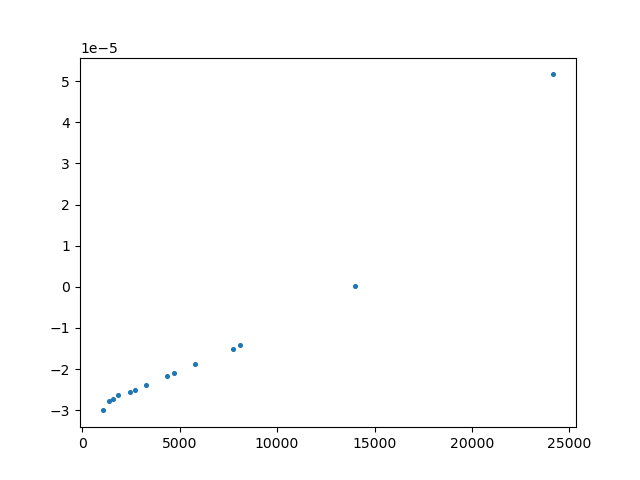

In [51]:
plt.close()
plt.scatter(x_list_, y_list_, s=7)

Определим функцию, под которую будем подгогять данные ($y=k*x+b$) и с помощью scipy определим подходящие параметры для прямой: $k$ и $b$. 

In [52]:
def model_f(x, k, b):
    return k*x + b

In [53]:
from scipy.optimize import curve_fit

In [54]:
popt, pcov = curve_fit(model_f, x_list_, y_list_, p0=[1,-3])

In [57]:
popt

array([ 3.24018996e-09, -3.53062703e-05])

In [58]:
k, b = popt

In [60]:
float(k)

3.2401899648458192e-09

In [61]:
float(b)

-3.530627032428535e-05

$$
(Z-1)V_m = B + \frac{C}{V_m}
$$
Коэффициент k соответствует вириальному коэффициенту C, а коэфициент b - вириальному коэффициенту B

Таким образом, 
$$
B = -3.53*10^{-5} (\text{л/моль})
$$

$$
C = 3.24*10^{-9} (\text{л/моль})^2
$$

In [63]:
x_model = np.linspace(min(x_list), max(x_list), 2)
y_model = model_f(x_model, k, b)

Изобразим все исходные данные на графике и прямую, которая была построена 

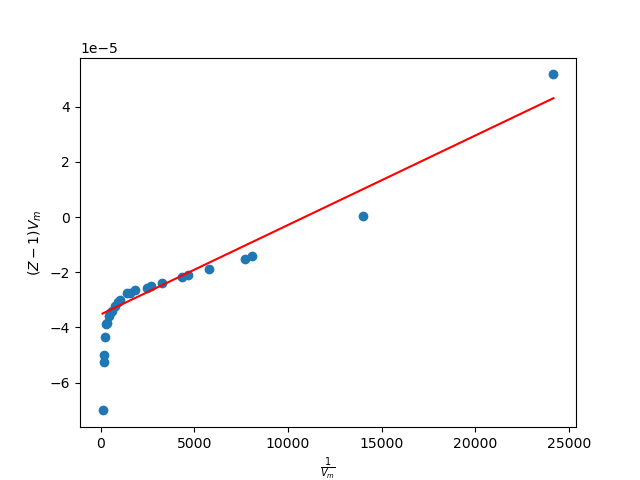

In [64]:
plt.close()
plt.scatter(x_list, y_list)
plt.plot(x_model, y_model, c='r')
plt.xlabel(r"$\frac{1}{V_m}$")
plt.ylabel(r"$(Z-1)V_m$")
plt.show()